In [5]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from tqdm import tqdm
from matplotlib.lines import Line2D

from cryptic_rnn import *

# Functions

In [81]:
def run_exp(trainseqs_old_b1 ,trainseqs_old_b2, trainseqs_old_p, testseqs_old, cue_dict):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    trainseqs = change_dict(trainseqs_old_b1, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset_b1 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    trainseqs = change_dict(trainseqs_old_b2, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset_b2 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    trainseqs = change_dict(trainseqs_old_p, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset_p = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
        
    # run primitive training RNN
    model_b1 = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    model_b2 = copy.deepcopy(model_b1)
    model_p = copy.deepcopy(model_b1)
    criterion = nn.MSELoss()
    
    optimizer = torch.optim.Adam(model_b1.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model_b1,optimizer,criterion, trainset_b1, [trainset_b1, testset], epochs, hidden_size)
    
    optimizer = torch.optim.Adam(model_b2.parameters(), lr=learningRate)
    loss2, acc2 = run_acc(model_b2,optimizer,criterion, trainset_b2, [trainset_b2, testset], epochs, hidden_size)
    
    optimizer = torch.optim.Adam(model_p.parameters(), lr=learningRate)
    loss3, acc3 = run_acc(model_p,optimizer,criterion, trainset_p, [trainset_p, testset], epochs, hidden_size)
    
       
    return {'cue_dict':cue_dict,'test': testset,
           'loss_b1':loss1, 'acc_b1':acc1, 'mod_b1': model_b1,\
           'loss_b2':loss2, 'acc_b2':acc2, 'mod_b2': model_b2,\
           'loss_p':loss3, 'acc_p':acc3, 'mod_p': model_p}

def run_plot(trainseqs_b1, trainseqs_b2, trainseqs_p, testseqs, cue_dict):
    
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs_b1, trainseqs_b2, trainseqs_p,testseqs, cue_dict) for i in tqdm(range(num_sims)))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)
    
    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    
    losses_b1 = np.hstack([r['loss_b1'] for r in res])
    acc_train_b1 = np.array([r['acc_b1'][:,0] for r in res]).T
    acc_test_b1 = np.array([r['acc_b1'][:,1] for r in res]).T
    mods_b1 = [r['mod_b1'] for r in res]

    losses_b2 = np.hstack([r['loss_b2'] for r in res])
    acc_train_b2 = np.array([r['acc_b2'][:,0] for r in res]).T
    acc_test_b2 = np.array([r['acc_b2'][:,1] for r in res]).T
    mods_b2 = [r['mod_b2'] for r in res]

    losses_p = np.hstack([r['loss_p'] for r in res])
    acc_train_p = np.array([r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array([r['acc_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]

    r2_b1, dfs_b1, _ = predcorr(mods_b1, tests, hidden_size, plot_corr =False)
    r2_b2, dfs_b2, _ = predcorr(mods_b2, tests, hidden_size, plot_corr = False)
    r2_p, dfs_p, _ = predcorr(mods_p, tests, hidden_size, plot_corr = False)

    print('B1: ', r2_b1)
    print('B2: ', r2_b2)
    print('P: ', r2_p)
    
    acc_df = pd.DataFrame({'acc_train_b1': acc_train_b1[-1,:], 'acc_test_b1': acc_test_b1[-1,:],\
                           'acc_train_b2': acc_train_b2[-1,:], 'acc_test_b2': acc_test_b2[-1,:],\
                           'acc_train_p': acc_test_p[-1,:], 'acc_test_p': acc_test_p[-1,:]})
    
    return {'mods_b1':mods_b1, 'mods_b2':mods_b2, 'mods_p':mods_p, \
            'res':res, 'tests': tests, 'cue_dicts': cue_dicts, 'acc_df':acc_df }

def extract_loss(res):
    losses_b = np.hstack([r['loss_b'] for r in res])
    losses_p = np.hstack([r['loss_p'] for r in res])
    return {'losses_b':losses_b,'losses_p':losses_p}

def extract_r2(res):
    
    tests = res['tests']
    mods_b1 = res['mods_b1']
    mods_b2 = res['mods_b2']
    mods_p = res['mods_p']

    r2_b1, sterr_b1 = get_r2s(mods_b1, tests, hidden_size)
    r2_b2, sterr_b2 = get_r2s(mods_b2, tests, hidden_size)
    r2_p, sterr_p = get_r2s(mods_p, tests, hidden_size)
    
    return [r2_b1, r2_b2,r2_p, sterr_b1, sterr_b2, sterr_p]
    
def get_r2s(mods, tests, hidden_size=20):
    N = len(mods)
    r2s = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        r2s.append(r2_score(df['pred'], df['label'])) # individual model r2 score
    r2_mean = np.mean(r2s)
    r2_sterr = np.std(r2s)/math.sqrt(N)
    
    return r2_mean, r2_sterr


    
def generate_pairs(op, inputs, cue_dict, shift):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    for s in range(shift):
        inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [(op, inputs1[i]), (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def input_frac_run(num_inputs, max_train_trials):
    
    all_syms = total_syms[:num_inputs]
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    cue_dict = {}
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    trial_list = []
    for s in range(1, len(all_syms)+1):
        trial_list += (generate_pairs(ops, all_syms, cue_dict, s))
    
    primitives = generate_pos_primitives(all_syms, cue_dict)
    balanced_prims1 = generate_balanced_primitives1(ops, all_syms, cue_dict)
    balanced_prims2 = generate_balanced_primitives2(ops, all_syms, cue_dict)
    
    train_trials = [trial for trial in trial_list if trial not in balanced_prims1 + balanced_prims2]
    
    reses = []
    for j in range(1, max_train_trials+1):
        print('##################\nnumber of train trials: ',j)      
        basic_train = train_trials[:j]
        trainseqs_b1 = basic_train + balanced_prims1
        trainseqs_b2 = basic_train + balanced_prims2
        trainseqs_p = basic_train + primitives
        testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
        testseqs = [t for t in testseqs if t not in trainseqs]
        res_j = run_plot(trainseqs_b1, trainseqs_b2, trainseqs_p, testseqs, cue_dict)
        reses.append(res_j)      
    
    return reses


## RNN params

In [10]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.0001

## running params
epochs = 1500
num_sims = 200

In [21]:
def generate_balanced_primitives1(op, inputs, cue_dict):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    n = int(len(inputs1)/2)
    for i in range(n):
        trial = [inputs1[i], (op, inputs2[i+n]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_balanced_primitives2(op, inputs, cue_dict):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    n = int(len(inputs1)/2)
    for i in range(n):
        trial = [inputs2[i+n], (op, inputs1[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


## Sequences

In [20]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print('cue_dict ',cue_dict)
primitives = generate_pos_primitives(all_syms, cue_dict)
print('primitives ',primitives)

trainseqs = generate_pos_other(ops, all_syms[:-1], cue_dict)
trainseqs_b = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_balanced_primitives(ops, all_syms, cue_dict)
trainseqs_p = trainseqs + primitives
trainseqs_bp = trainseqs_b + primitives

print('trainseqs ',trainseqs)
print('trainseqs_b ',trainseqs_b)
print('trainseqs_p ',trainseqs_p)
print('trainseqs_bp ',trainseqs_bp)

testseqs_all = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in testseqs_all if seq not in trainseqs_b]
valset_idx = [idx for idx, seq in enumerate(testseqs_all) if seq not in trainseqs_b]

print('testseqs ', testseqs )

cue_dict  {'A': 14, 'B': 3, 'C': 10, 'D': 17}
primitives  [[('+', 'A'), '=', 14], [('+', 'B'), '=', 3], [('+', 'C'), '=', 10], [('+', 'D'), '=', 17]]
trainseqs  [[('+', 'A'), ('+', 'B'), '=', 17], [('+', 'B'), ('+', 'C'), '=', 13], [('+', 'C'), ('+', 'A'), '=', 24]]
trainseqs_b  [[('+', 'A'), ('+', 'B'), '=', 17], [('+', 'B'), ('+', 'C'), '=', 13], [('+', 'C'), ('+', 'A'), '=', 24], ['A', ('+', 'C'), '=', 24], ['B', ('+', 'D'), '=', 20]]
trainseqs_p  [[('+', 'A'), ('+', 'B'), '=', 17], [('+', 'B'), ('+', 'C'), '=', 13], [('+', 'C'), ('+', 'A'), '=', 24], [('+', 'A'), '=', 14], [('+', 'B'), '=', 3], [('+', 'C'), '=', 10], [('+', 'D'), '=', 17]]
trainseqs_bp  [[('+', 'A'), ('+', 'B'), '=', 17], [('+', 'B'), ('+', 'C'), '=', 13], [('+', 'C'), ('+', 'A'), '=', 24], ['A', ('+', 'C'), '=', 24], ['B', ('+', 'D'), '=', 20], [('+', 'A'), '=', 14], [('+', 'B'), '=', 3], [('+', 'C'), '=', 10], [('+', 'D'), '=', 17]]
testseqs  [[('+', 'A'), ('+', 'A'), '=', 28], [('+', 'A'), ('+', 'C'), '=', 24], 

##################
number of train trials:  1


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2732.22it/s]


run time:  0.5845608989397685
##################
number of train trials:  2


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8413.85it/s]


run time:  0.6524415810902914
##################
number of train trials:  3


100%|██████████████████████████████████████████| 8/8 [00:00<00:00, 10855.53it/s]


run time:  0.7257358630498251
##################
number of train trials:  4


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 7311.93it/s]


run time:  6.630421733856201


/Users/miahannah/compositional_learning_MW/_run_RNNs/cryptic_rnn.py:564: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 1)


##################
number of train trials:  5


100%|██████████████████████████████████████████| 8/8 [00:00<00:00, 11785.89it/s]


run time:  0.8778680483500163
##################
number of train trials:  6


100%|██████████████████████████████████████████| 8/8 [00:00<00:00, 11958.10it/s]


run time:  0.9387608846028646
##################
number of train trials:  7


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 8557.62it/s]


run time:  1.4153663516044617
##################
number of train trials:  8


100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 7545.41it/s]


run time:  1.1321016192436217
##################
number of train trials:  9


100%|██████████████████████████████████████████| 8/8 [00:00<00:00, 10665.74it/s]


run time:  1.1942951321601867


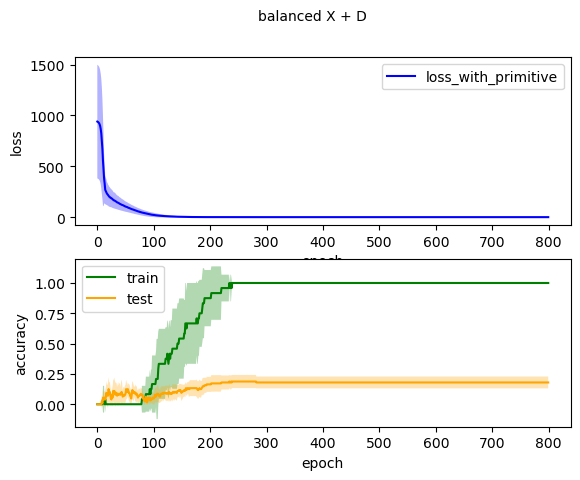

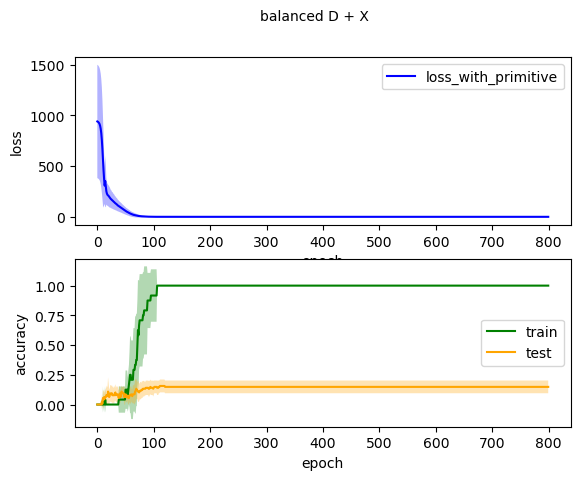

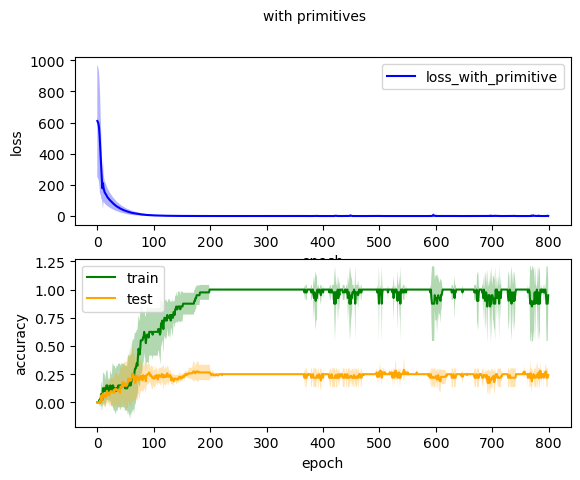

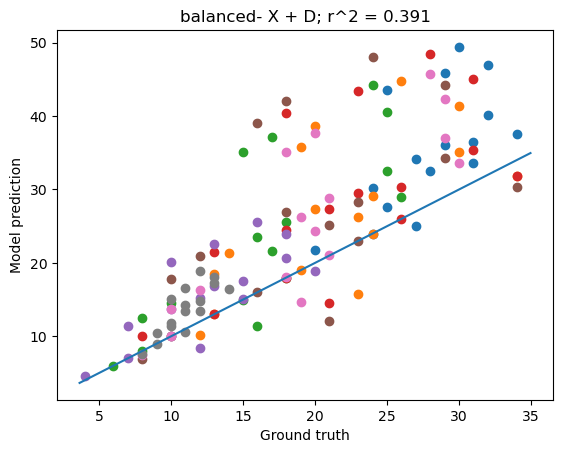

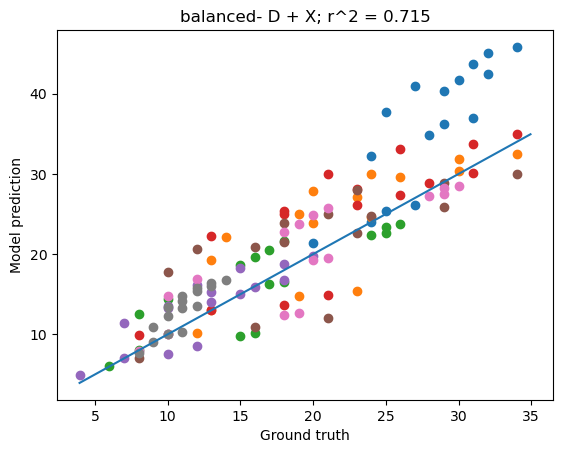

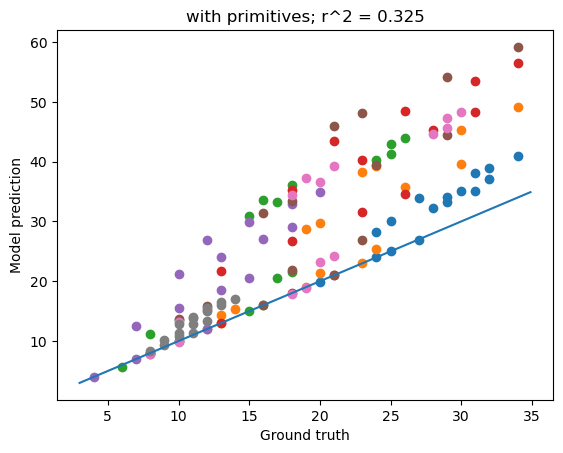

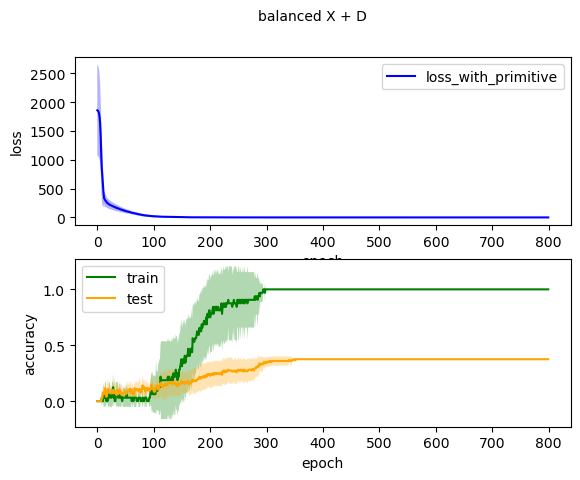

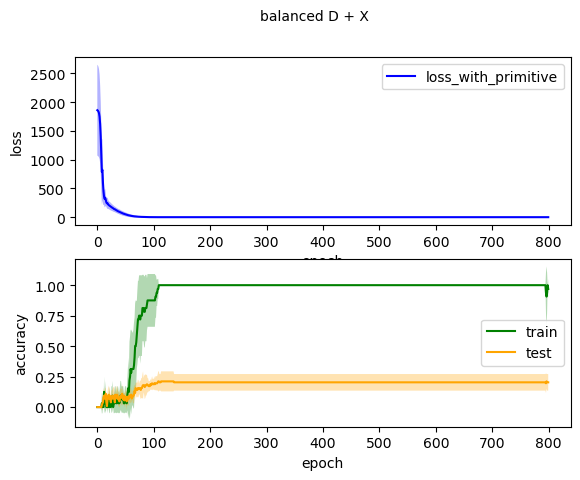

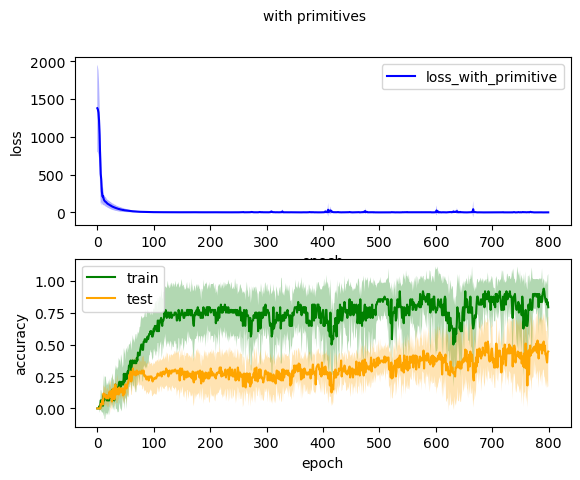

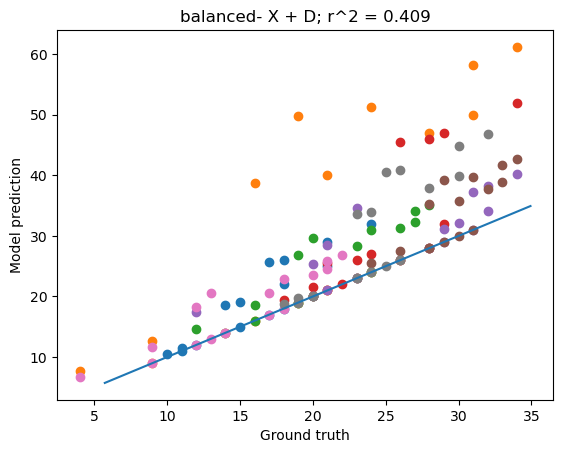

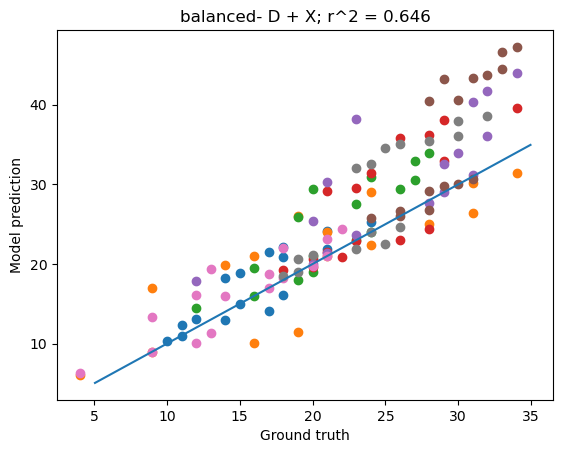

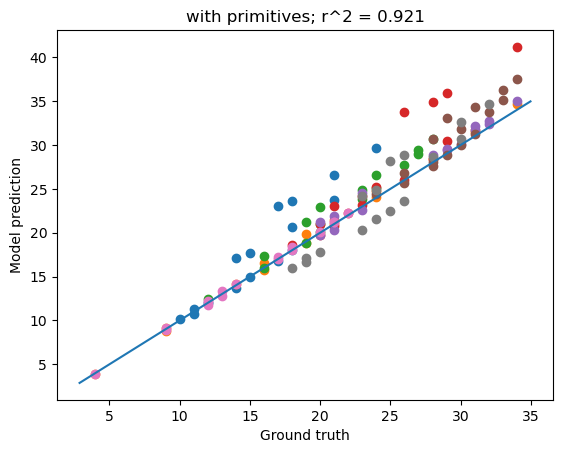

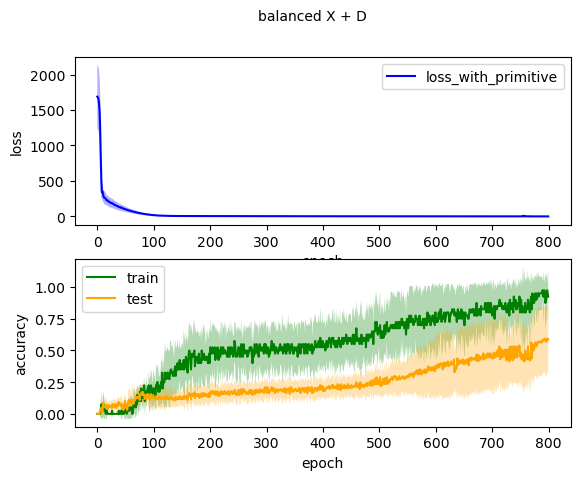

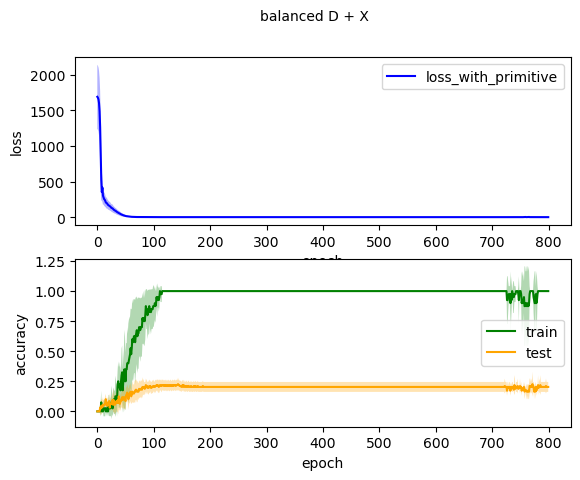

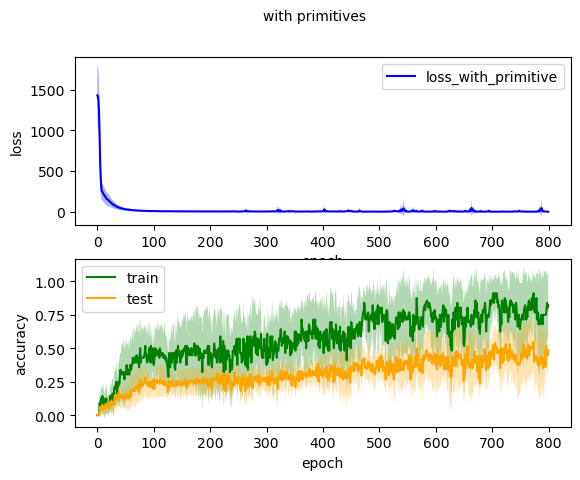

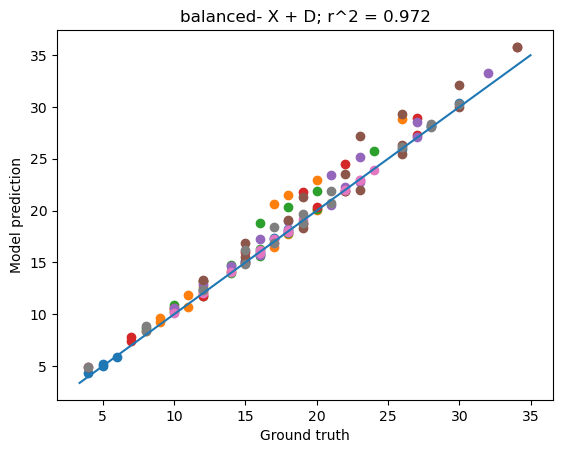

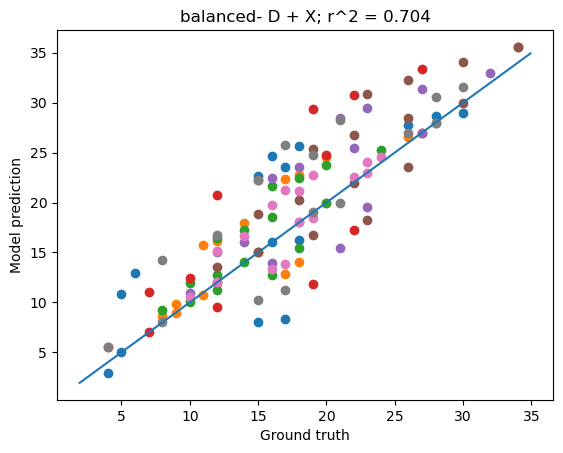

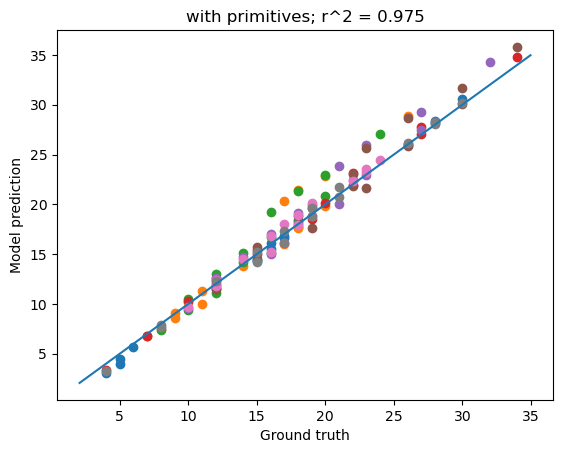

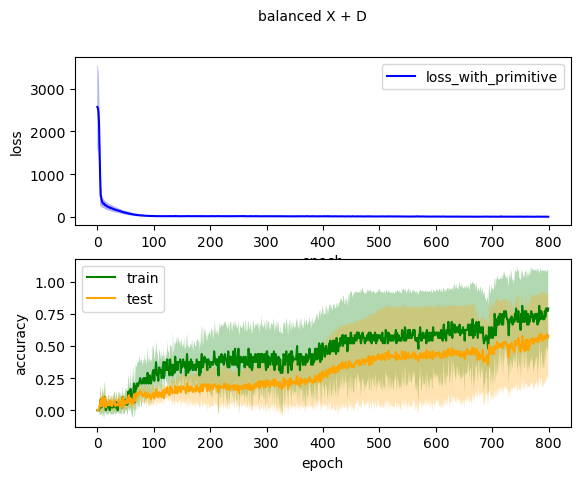

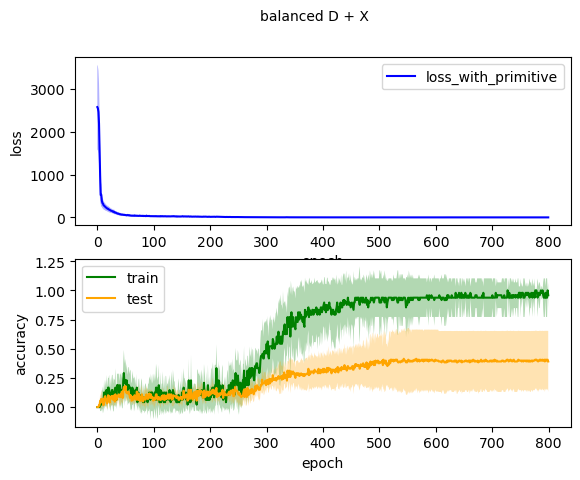

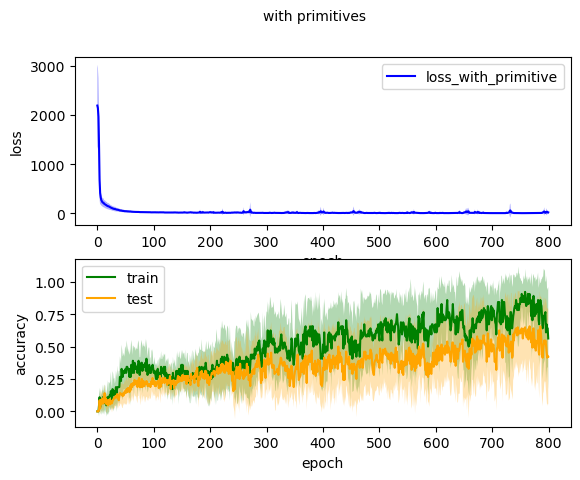

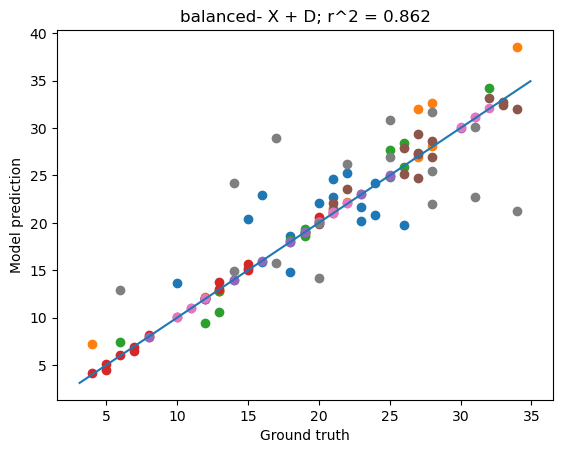

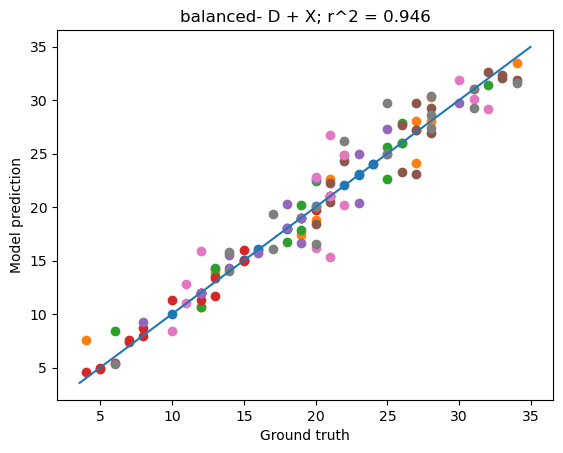

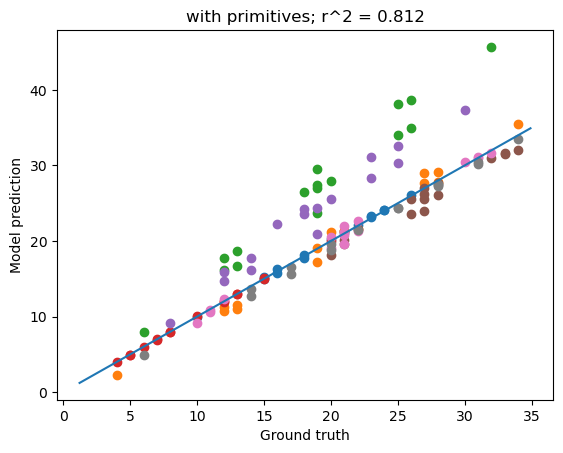

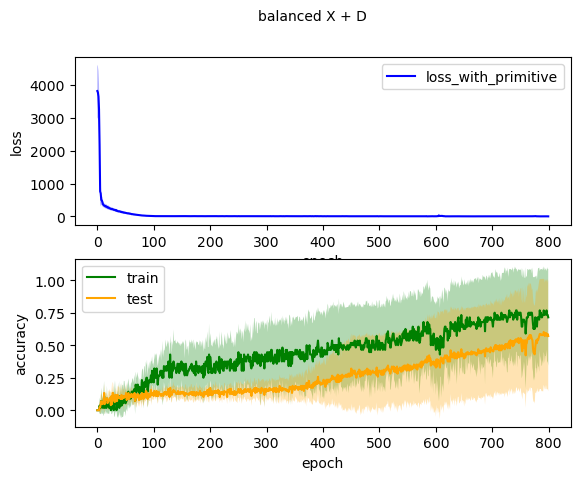

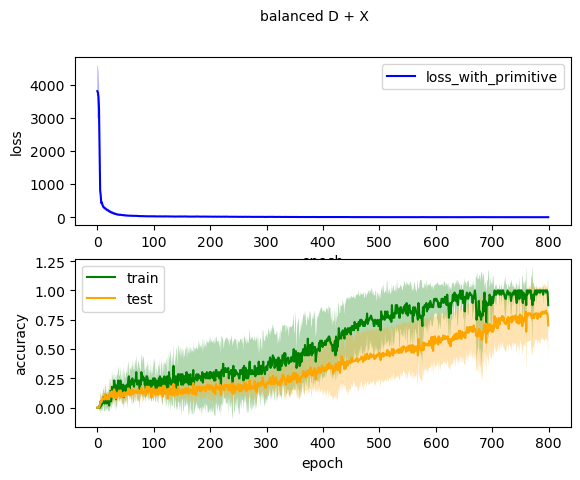

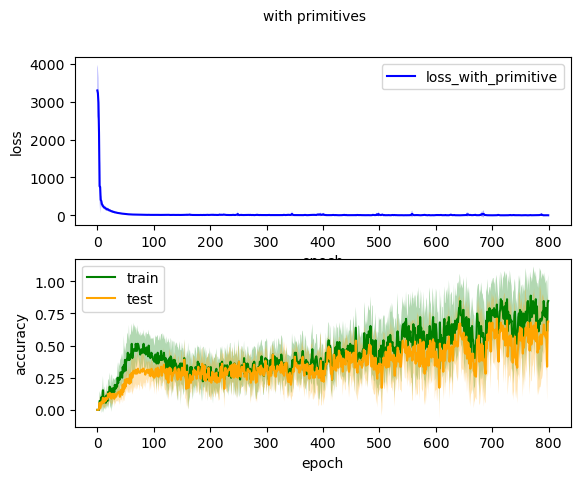

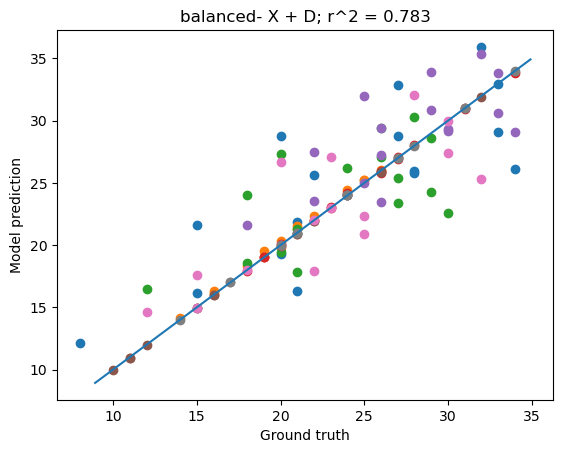

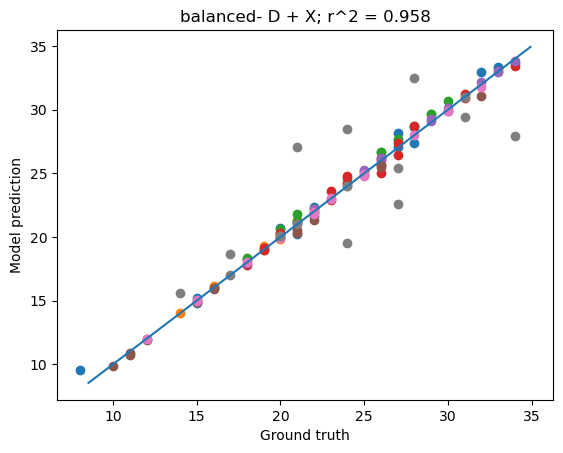

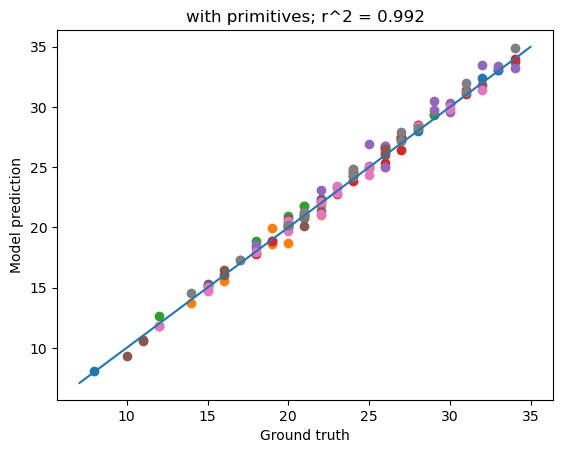

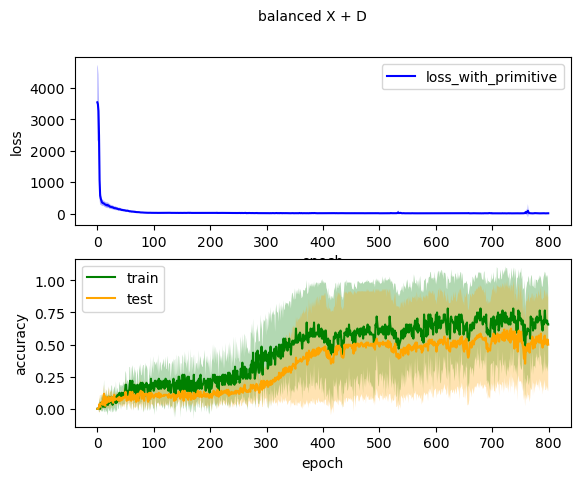

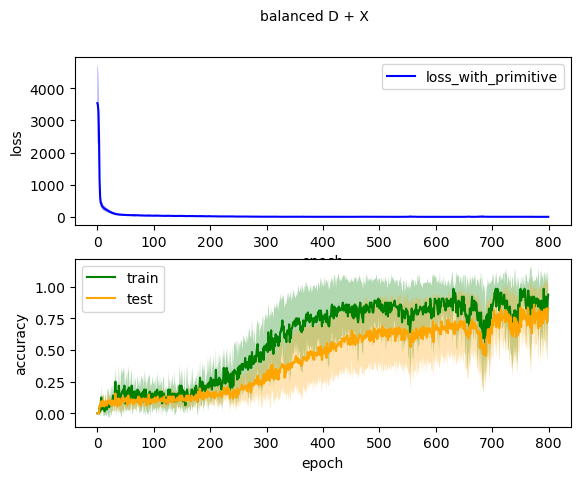

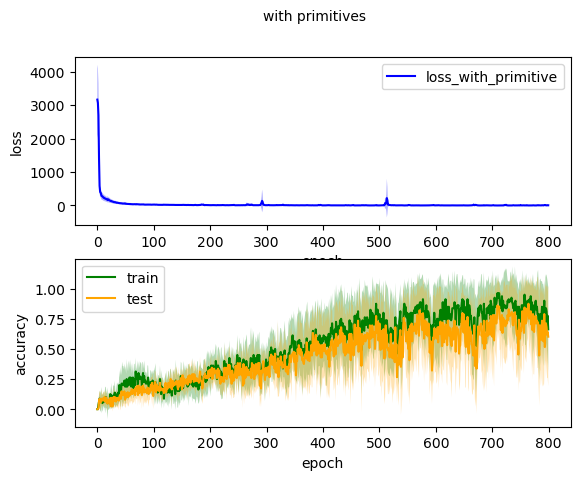

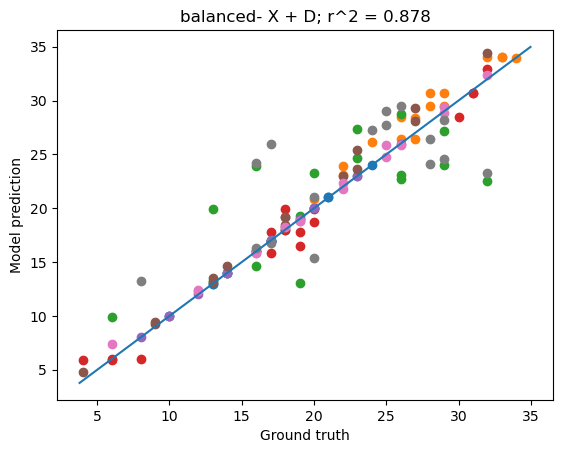

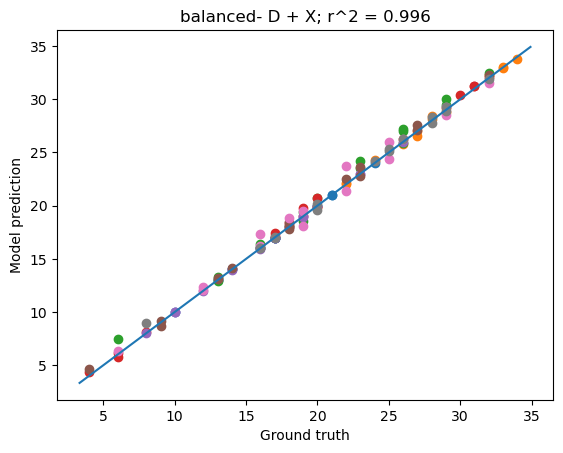

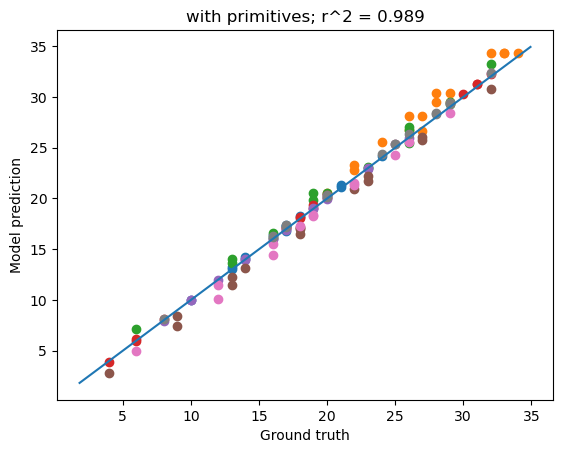

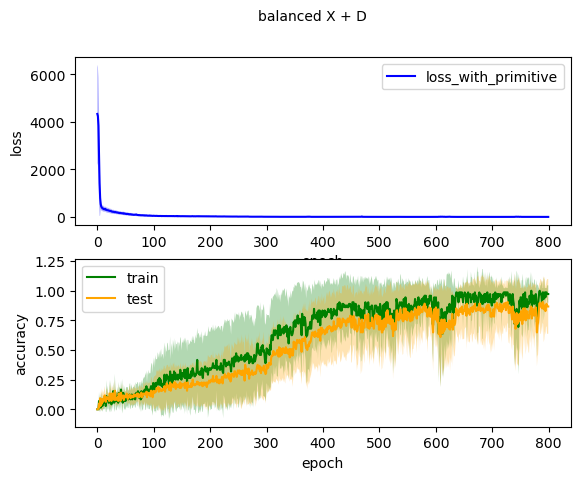

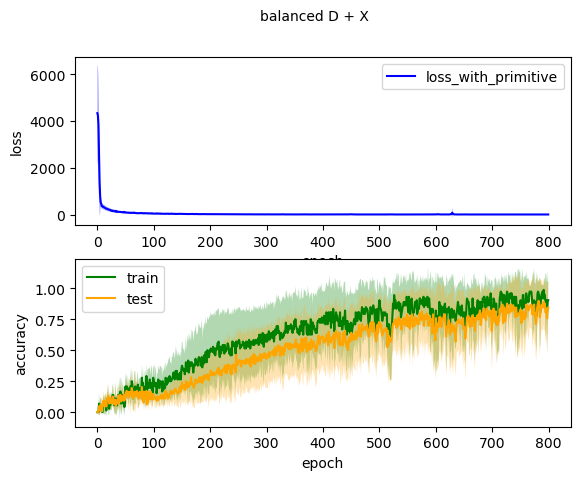

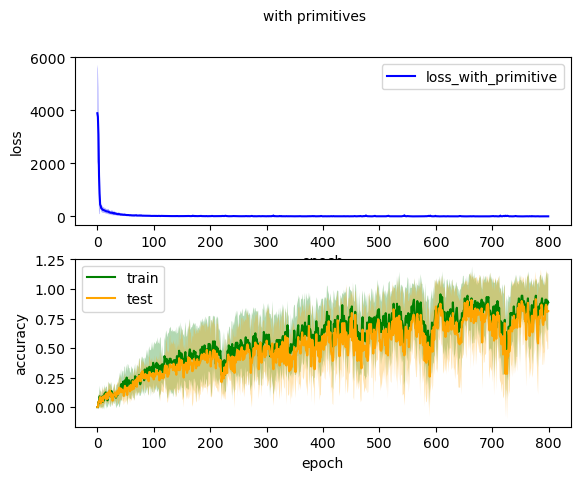

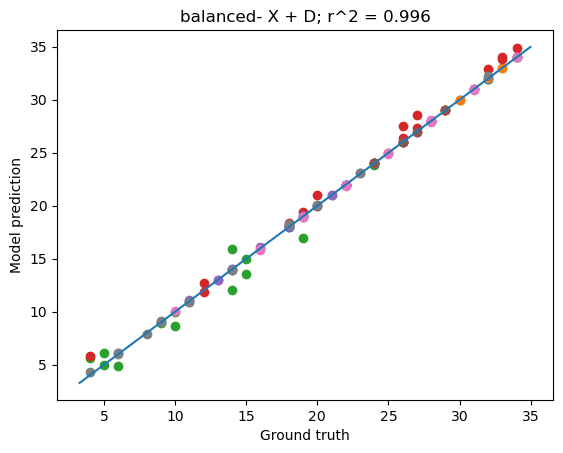

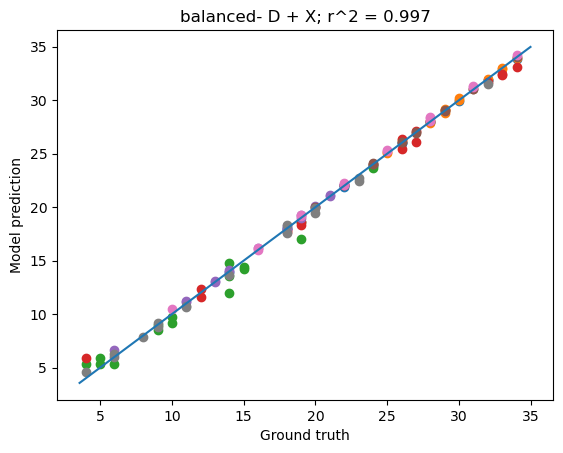

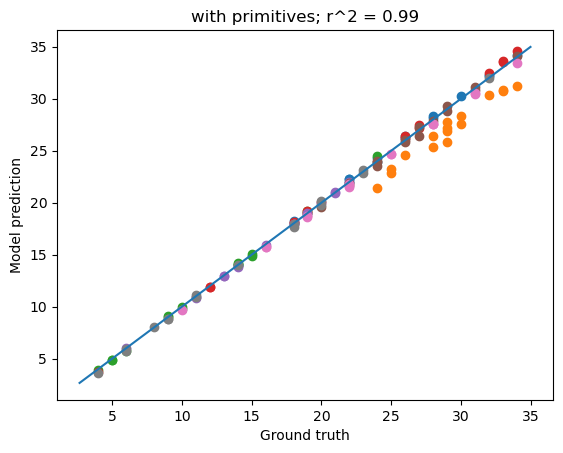

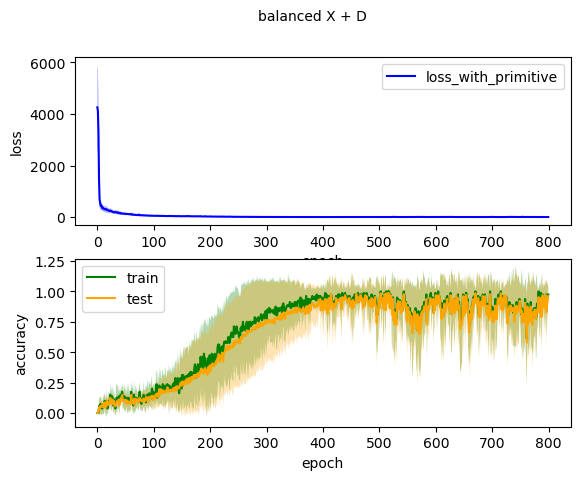

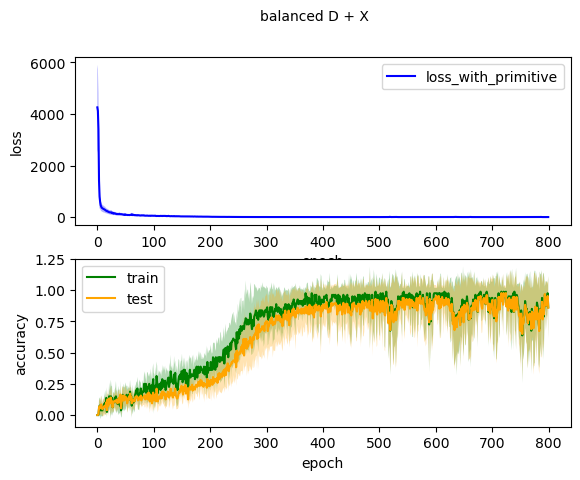

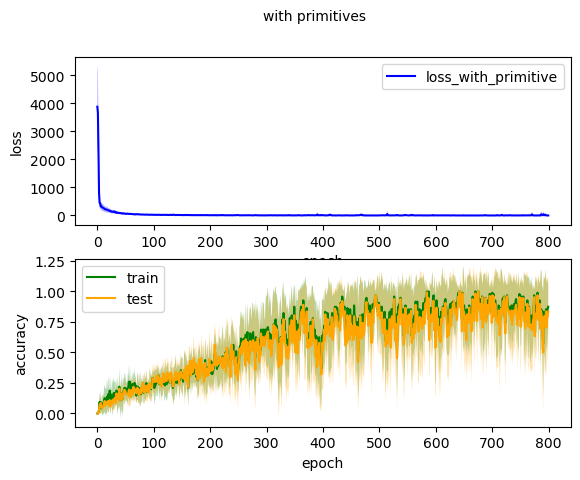

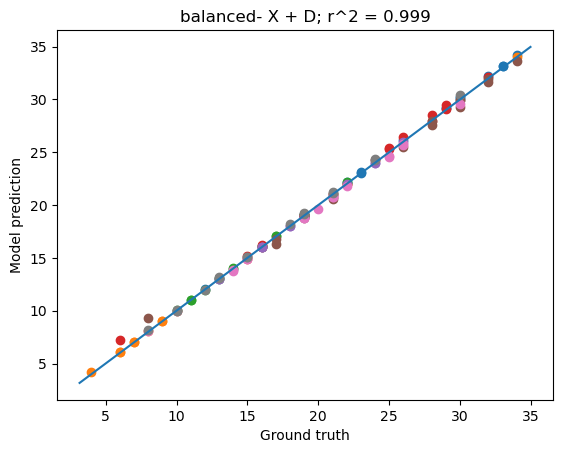

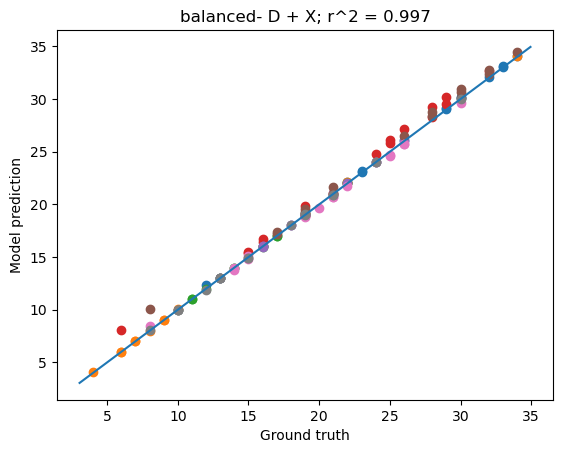

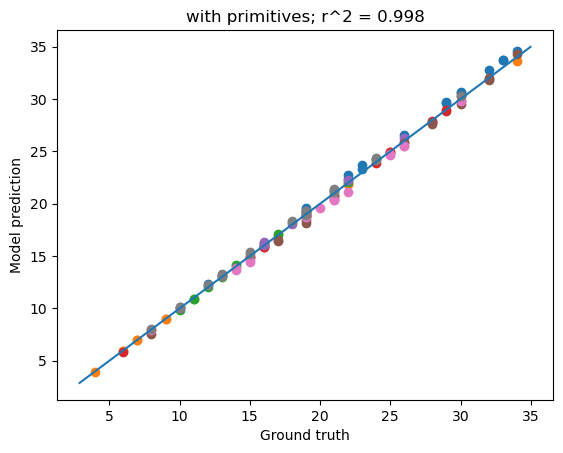

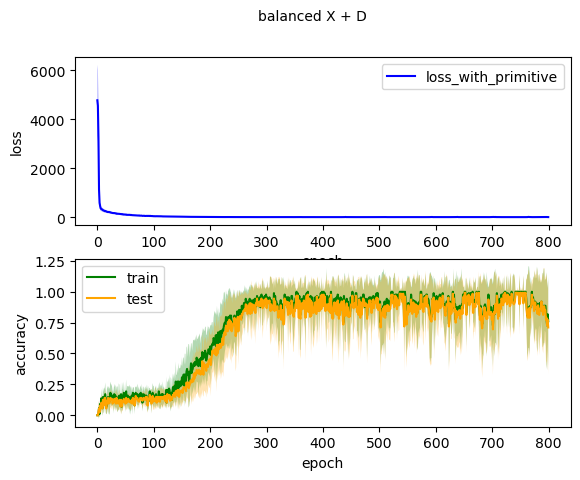

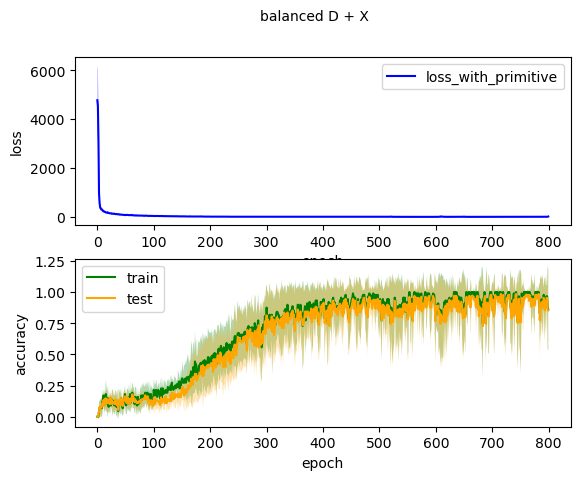

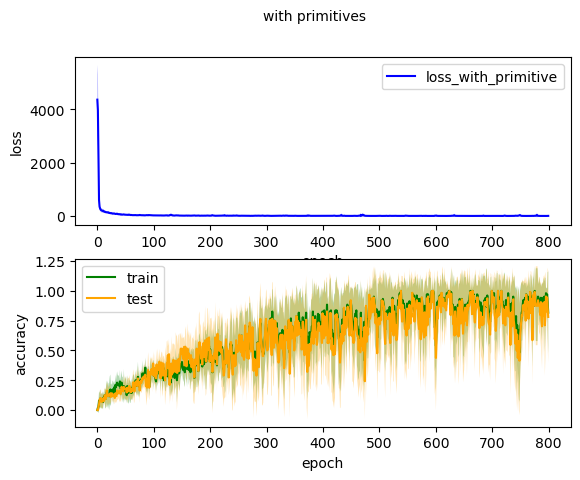

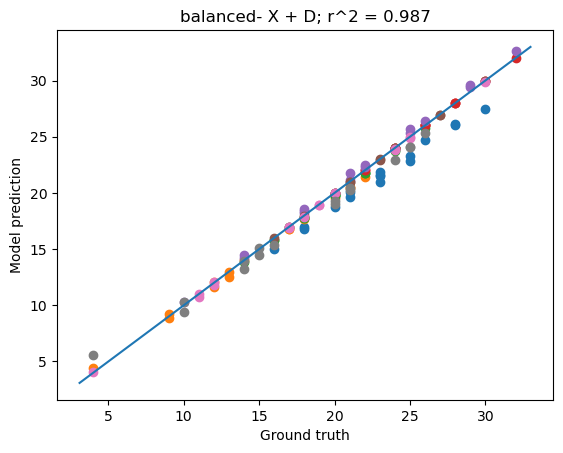

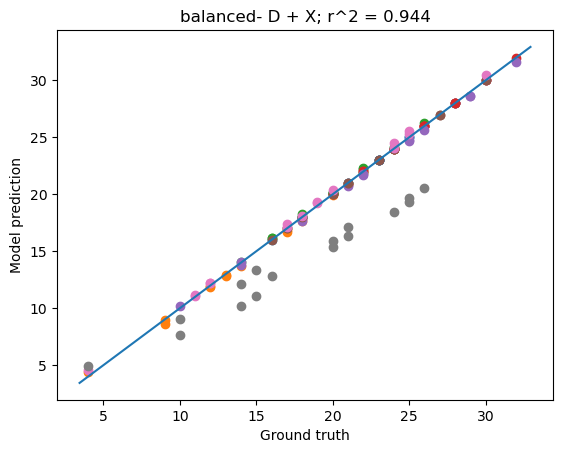

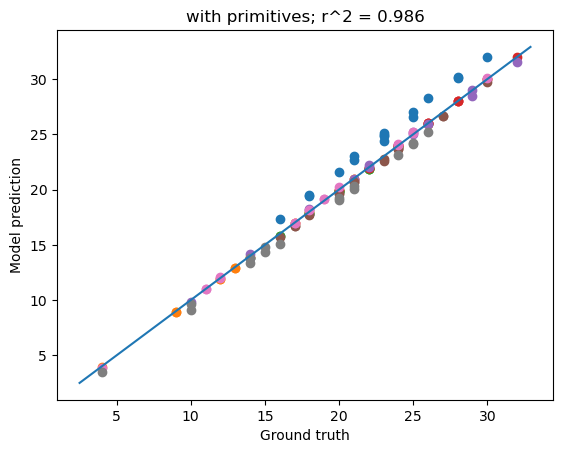

In [49]:
epochs = 800
num_sims = 8
res = input_frac_run(4, 9)

In [50]:
len(res)

9

## we want a list of mean r2 vals for each trian_no. for each condition (3 lists)
## and corresponding list of standdard error (3)

In [93]:
vals = np.empty((0,6))
for i, res_set in enumerate(res):
    set_vals = np.array(extract_r2(res_set)).reshape(-1,6)
    vals = np.vstack([vals, set_vals])


Text(0, 0.5, 'Prediction vs ground truth R squared')

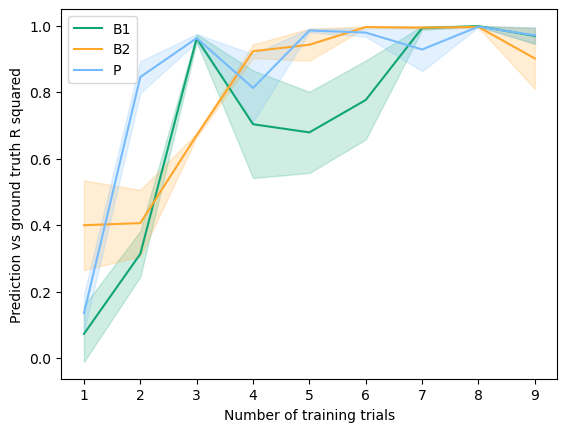

In [107]:
j = 0
labels = ['B1', 'B2', 'P']
colors = ['#10a674', '#ffa62b', '#75bbfd']

nn = int(vals.shape[1]/2)
for j in range(nn):
    plt.plot(xpos, vals[:,j], label = labels[j], color=colors[j])
    plt.fill_between(xpos, vals[:,j] + vals[:,j+nn], vals[:,j] - vals[:,j+nn], color=colors[j], alpha=0.2)
plt.legend()
plt.xlabel('Number of training trials')
plt.ylabel('Prediction vs ground truth R squared')

In [ ]:
xpos = np.arange(1, len(r2_b1)+1)
plt.plot(xpos, r2_b1, label = 'Balanced1')
plt.plot(xpos, r2_b2, label = 'Balanced2')
plt.plot(xpos, r2_p, label = 'Primitives')
plt.fill_between(xpos, r2_b1 + sterr_b1, r2_b1 - sterr_b1)
plt.legend()

In [72]:
r2_b1 = []
r2_b2 = []
r2_p = []
sterr_b1 = []
sterr_b2 = []
sterr_p = []

# get mean r2 and std for each set
for i, res_set in enumerate(res):
    all_vals = extract_r2(res_set)
    r2_b1.append(all_vals['r2_b1'])
    r2_b2.append(all_vals['r2_b2'])
    r2_p.append(all_vals['r2_p'])
    sterr_b1.append(all_vals['sterr_b1'])
    sterr_b2.append(all_vals['sterr_b2'])
    sterr_p.append(all_vals['sterr_p'])


TypeError: unsupported operand type(s) for -: 'list' and 'list'

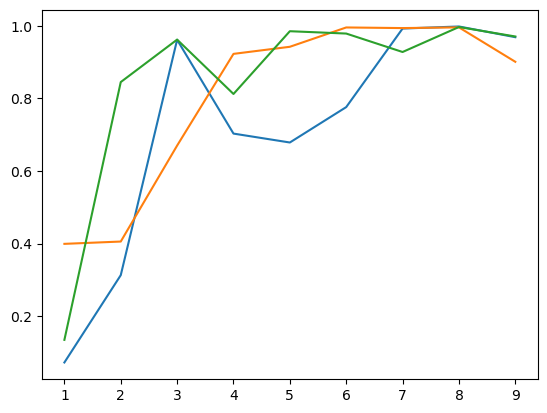

In [63]:
g = extract_r2(res[i])
g

{'r2_b1': 0.07268556479118485,
 'r2_b2': 0.39947725547579205,
 'r2_p': 0.13500676582230886,
 'sterr_b1': 0.08433838249282642,
 'sterr_b2': 0.13478596528232029,
 'sterr_p': 0.05559272515450815}

In [66]:
g.loc[0]

AttributeError: 'dict' object has no attribute 'loc'

In [55]:
len(res[i]['mods_b1'])

8

In [30]:
generate_balanced_primitives2(ops, all_syms, cue_dict)


[['C', ('+', 'A'), '=', 24], ['D', ('+', 'B'), '=', 20]]

In [26]:
trainseqs_b1 = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_balanced_primitives1(ops, all_syms, cue_dict)
trainseqs_b2 = generate_pos_other(ops, all_syms[:-1], cue_dict) + generate_balanced_primitives2(ops, all_syms, cue_dict)

testseqs_all = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs = [seq for seq in testseqs_all if seq not in trainseqs_b]
valset_idx = [idx for idx, seq in enumerate(testseqs_all) if seq not in trainseqs_b]

print('testseqs ', testseqs )

testseqs  [[('+', 'A'), ('+', 'A'), '=', 28], [('+', 'A'), ('+', 'C'), '=', 24], [('+', 'A'), ('+', 'D'), '=', 31], [('+', 'B'), ('+', 'A'), '=', 17], [('+', 'B'), ('+', 'B'), '=', 6], [('+', 'B'), ('+', 'D'), '=', 20], [('+', 'C'), ('+', 'B'), '=', 13], [('+', 'C'), ('+', 'C'), '=', 20], [('+', 'C'), ('+', 'D'), '=', 27], [('+', 'D'), ('+', 'A'), '=', 31], [('+', 'D'), ('+', 'B'), '=', 20], [('+', 'D'), ('+', 'C'), '=', 27], [('+', 'D'), ('+', 'D'), '=', 34]]


In [27]:
epochs = 1000
num_sims=8

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 48.50it/s]


run time:  0.7072998722394307


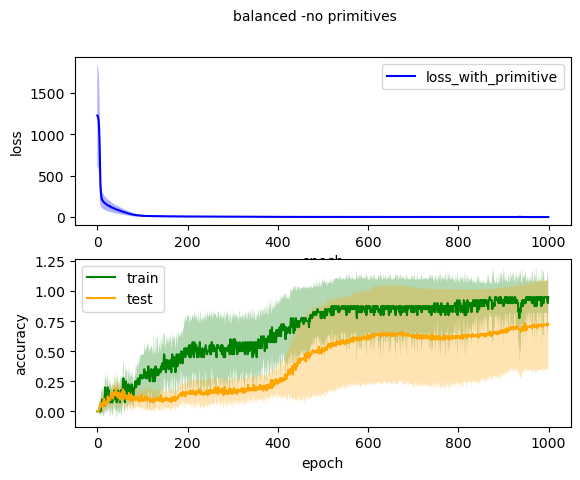

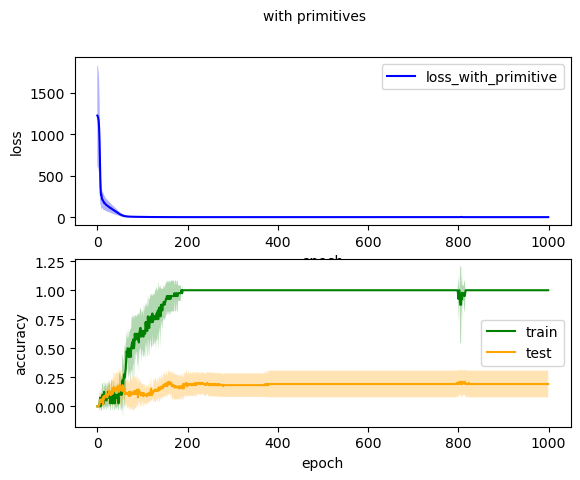

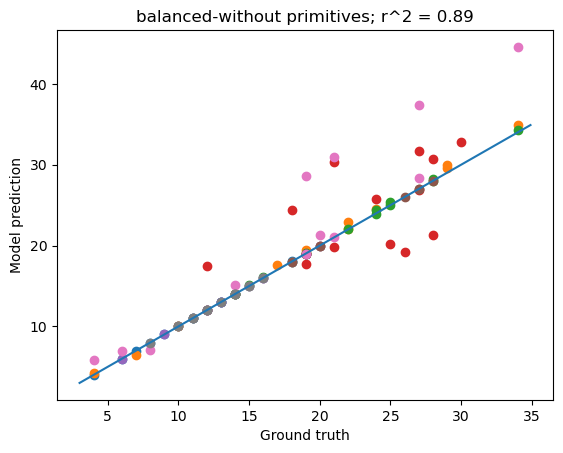

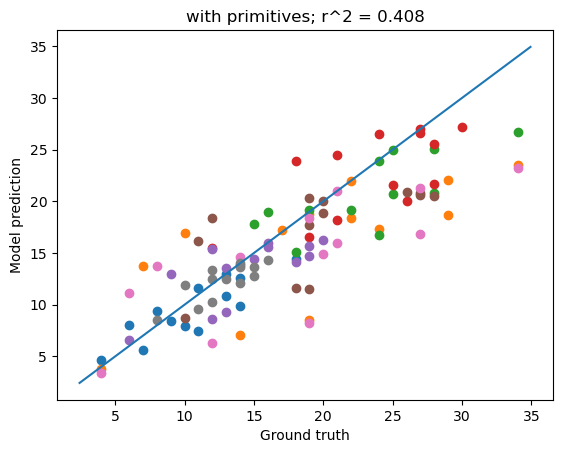

In [29]:
res1 = run_plot(trainseqs_b1, trainseqs_b2, testseqs, cue_dict)